# TF Complex Screening

Covariance screening process.

The process involves:
    - Correlation testing with every other gene
    - Find potential gene-TF1-TF2 trios by finding overlaps of genes
    - Conditional independence testing (for every level of gene, are TF1 and TF2 independent?)
    - Causal inference (direction of arrows), for TF1-KO, does the correlation betwen TF1 and G decrease?
    - Mediation test, for TF1-KO, does the correlation between TF2 and G decrease?
    - If all of the tests pass, we retain it for our final graph.

### Import

In [20]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [21]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [22]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import imp
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import pickle as pkl
import networkx as nx

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

In [27]:
import scanpy.api as sc
import itertools
%matplotlib inline

In [65]:
"""
	process.py
	This file contains the high level calls for the steps in the TF interaction analysis.
"""

def extract_ko_gene(adata, guide_cov='guide_cov'):
	""" Given an anndata object, extract the KO target gene from the guide. """

	adata.obs['ko_gene_cov'] = adata.obs[guide_cov].str.extract(r'^([^.]*).*')


def filter_gene_list(adata, guide_de_fname, min_count=60):
	""" Filter the gene list by a DE by guide analysis. """

	# Identify transcription factors that were knocked out.
	# These are included automatically, as long as they were in the original 3k vargene list.
	guide_de_df = pd.read_csv(guide_de_fname, sep='\t')
	tfs = set(guide_de_df['cluster'].str.extract(r'^([^.]*).*').iloc[:,0].unique().tolist())
	tfs &= set(adata.var.index.tolist())
	tfs = list(tfs)
	print('Number of eligible TFs:', len(tfs))

	# Get a list of genes that are differentially expressed in many of the guides.
	counts = guide_de_df.gene.value_counts()
	de_genes = counts[counts > 60].index.tolist()

	# Filter the annotated data object
	all_genes = de_genes + tfs
	adata._inplace_subset_var(all_genes)
	embedded_adata.var_names_make_unique()

### Define my TFs

In [28]:
tfs_considered = ['IRF1', 'JUN', 'JUNB', 'MYC', 'NFKBIA', 'SMAD2', 'SP1', 'STAT1', 'STAT3', 'STAT5A', 'STAT6']

### Read into scanpy

Filter genes to the DE genes identified above.

In [29]:
embedded_adata = sc.read('/Users/mincheolkim/Documents/nsnp20.raw.sng.guide_sng.norm.h5ad')

In [30]:
embedded_adata.obs['ko_gene_cov'] = embedded_adata.obs['guide_cov'].str.extract(r'^([^.]*).*')

In [32]:
embedded_adata

AnnData object with n_obs × n_vars = 258946 × 3276 
    obs: 'guide_cov', 'donor_cov', 'well_cov', 'numi_cov', 'multiplet_cov', 'nsnp_cov', 'percent_mito', 'n_counts', 'louvain', 'ko_gene_cov'
    var: 'gene_ids', 'n_counts'
    uns: 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

### Read in DE genes and filter the gene list in annotated data

In [62]:
de_filename = '/Users/mincheolkim/Documents/nsnp20.raw.sng.guide_sng.norm.vs0.igtb.guide.de.seurate.txt.meta.guide.meta.sig.txt'

In [66]:
filter_gene_list(embedded_adata, de_filename)

Number of eligible TFs: 38
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Transcription factors

In [24]:
for tf in tfs_considered:
    print(tf)

IRF1
JUN
JUNB
MYC
NFKBIA
SMAD2
SP1
STAT1
STAT3
STAT5A
STAT6


### Read known interactions from String DB

I put in the list of TFs above, and got the interaction map. From the interaction map, I only retain those with experimentally determined interaction.

In [25]:
known_interactions = pd.read_csv('/Users/mincheolkim/Documents/string_interactions (1).tsv', sep='\t')\
    .query('experimentally_determined_interaction > 0')

In [26]:
edge_set = set()
truth_graph = nx.Graph()
for idx, row in known_interactions.iterrows():
    tf1, tf2 = sorted([row['#node1'], row['node2']])
    truth_graph.add_edge(tf1, tf2)
    edge_set.add(tf1 + '_' + tf2)

### Correlation testing for each of these TFs

For each TF, find genes that correlate with it.

In [27]:
hits = {}
count = 0
for tf in tfs_considered:
    print('Getting correlated genes for {}..'.format(tf))
    corrs = []
    pvals = []
    for gene in embedded_adata.var.index.tolist():
        corr, pval = spearmanr(
            embedded_adata.X[(embedded_adata.obs.guide_cov == "0").values, embedded_adata.var.index.tolist().index(tf)],
            embedded_adata.X[(embedded_adata.obs.guide_cov == "0").values, embedded_adata.var.index.tolist().index(gene)])
        corrs.append(corr)
        pvals.append(pval)
    hits[tf] = embedded_adata.var.index[(np.array(pvals) < 0.05/(len(tfs_considered)*embedded_adata.shape[1])) & (np.array(corrs) > 0)].tolist()

Getting correlated genes for IRF1..
Getting correlated genes for JUN..
Getting correlated genes for JUNB..
Getting correlated genes for MYC..
Getting correlated genes for NFKBIA..
Getting correlated genes for SMAD2..
Getting correlated genes for SP1..
Getting correlated genes for STAT1..
Getting correlated genes for STAT3..
Getting correlated genes for STAT5A..
Getting correlated genes for STAT6..


In [28]:
for tf, genes in hits.items():
    print(tf, len(genes))

IRF1 717
JUN 886
JUNB 686
MYC 467
NFKBIA 509
SMAD2 477
SP1 450
STAT1 541
STAT3 773
STAT5A 725
STAT6 678


### Get direction of the correlation by using KO information

In [29]:
directed_hits = {}
for tf in tfs_considered:
    directed_hits[tf] = []
    print('Getting correlated genes for {}..'.format(tf))
    for gene in hits[tf]:
        corr, pval = spearmanr(
            embedded_adata.X[(embedded_adata.obs.ko_gene_cov == tf).values, embedded_adata.var.index.tolist().index(tf)],
            embedded_adata.X[(embedded_adata.obs.ko_gene_cov == tf).values, embedded_adata.var.index.tolist().index(gene)])
        if pval > 0.05/(len(tfs_considered)*embedded_adata.shape[1]):
            directed_hits[tf].append(gene)

Getting correlated genes for IRF1..
Getting correlated genes for JUN..
Getting correlated genes for JUNB..
Getting correlated genes for MYC..
Getting correlated genes for NFKBIA..
Getting correlated genes for SMAD2..
Getting correlated genes for SP1..
Getting correlated genes for STAT1..
Getting correlated genes for STAT3..
Getting correlated genes for STAT5A..
Getting correlated genes for STAT6..


In [30]:
for tf, genes in directed_hits.items():
    print(tf, len(genes))

IRF1 116
JUN 42
JUNB 49
MYC 316
NFKBIA 127
SMAD2 38
SP1 155
STAT1 140
STAT3 80
STAT5A 42
STAT6 115


### For each TF pair, find the genes that they both are correlated with

In [31]:
tf_gene_overlaps = {}
tf_gene_overlap_counts = {}

In [32]:
for tf1, tf2 in itertools.combinations(sorted(directed_hits.keys()), 2):
    overlap = set(directed_hits[tf1]) & set(directed_hits[tf2])
    if len(overlap) > 0:
        tf_gene_overlaps[tf1 + '_' + tf2] = overlap
        tf_gene_overlap_counts[tf1 + '_' + tf2] = len(overlap)

In [33]:
tf_gene_overlap_counts

{'IRF1_JUN': 21,
 'IRF1_JUNB': 32,
 'IRF1_MYC': 34,
 'IRF1_NFKBIA': 14,
 'IRF1_SMAD2': 4,
 'IRF1_SP1': 27,
 'IRF1_STAT1': 6,
 'IRF1_STAT3': 46,
 'IRF1_STAT5A': 19,
 'IRF1_STAT6': 45,
 'JUN_JUNB': 18,
 'JUN_MYC': 4,
 'JUN_NFKBIA': 8,
 'JUN_SMAD2': 2,
 'JUN_SP1': 2,
 'JUN_STAT1': 3,
 'JUN_STAT3': 17,
 'JUN_STAT5A': 15,
 'JUN_STAT6': 14,
 'JUNB_MYC': 11,
 'JUNB_NFKBIA': 8,
 'JUNB_SMAD2': 2,
 'JUNB_SP1': 3,
 'JUNB_STAT1': 3,
 'JUNB_STAT3': 23,
 'JUNB_STAT5A': 19,
 'JUNB_STAT6': 25,
 'MYC_NFKBIA': 65,
 'MYC_SMAD2': 25,
 'MYC_SP1': 75,
 'MYC_STAT1': 97,
 'MYC_STAT3': 23,
 'MYC_STAT5A': 15,
 'MYC_STAT6': 19,
 'NFKBIA_SMAD2': 10,
 'NFKBIA_SP1': 28,
 'NFKBIA_STAT1': 47,
 'NFKBIA_STAT3': 13,
 'NFKBIA_STAT5A': 4,
 'NFKBIA_STAT6': 13,
 'SMAD2_SP1': 18,
 'SMAD2_STAT1': 10,
 'SMAD2_STAT3': 5,
 'SMAD2_STAT5A': 1,
 'SMAD2_STAT6': 9,
 'SP1_STAT1': 24,
 'SP1_STAT3': 10,
 'SP1_STAT5A': 5,
 'SP1_STAT6': 20,
 'STAT1_STAT3': 6,
 'STAT1_STAT5A': 5,
 'STAT1_STAT6': 7,
 'STAT3_STAT5A': 11,
 'STAT3_STAT6': 39,


### For each TF pair, perform differential correlation analysis with target gene

In [34]:
def correlation(g1, g2, label, label_col='ko_gene_cov'):
    return spearmanr(
        embedded_adata.X[(embedded_adata.obs[label_col] == label).values, embedded_adata.var.index.tolist().index(g1)],
        embedded_adata.X[(embedded_adata.obs[label_col] == label).values, embedded_adata.var.index.tolist().index(g2)])

In [35]:
def differential_correlation(g1, g2, label_1, label_2, label_col='ko_gene_cov'):
    corr_1, pval_1 = correlation(g1, g2, label_1, label_col)
    corr_2, pval_2 = correlation(g1, g2, label_2, label_col)
    
    n_1 = (embedded_adata.obs[label_col] == label_1).sum()
    n_2 = (embedded_adata.obs[label_col] == label_2).sum()
    
    return (np.arctanh(corr_1) - np.arctanh(corr_2))/(np.sqrt(np.absolute((1/n_1) - (1/n_2))))

In [36]:
all_stats = {}
for pair, genes in tf_gene_overlaps.items():
    genes = tf_gene_overlaps[pair]
    tf1, tf2 = pair.split('_')
    all_stats[pair] = {}
    for gene in genes:
        if gene == tf1 or gene == tf2:
            continue
        all_stats[pair][gene] = (
            differential_correlation(gene, tf2, '0', tf1),
            differential_correlation(gene, tf1, '0', tf2))

### Generate null distribution

In [37]:
embedded_adata.obs['shuffled_ko_gene_cov'] = embedded_adata.obs['ko_gene_cov'].values[np.random.permutation(len(embedded_adata.obs))]

In [38]:
null_stats = []
for pair, genes in tf_gene_overlaps.items():
    genes = tf_gene_overlaps[pair]
    tf1, tf2 = pair.split('_')
    for gene in genes:
        null_stats.append(differential_correlation(gene, tf2, '0', tf1, label_col='shuffled_ko_gene_cov'))
        null_stats.append(differential_correlation(gene, tf1, '0', tf2, label_col='shuffled_ko_gene_cov'))
null_stats = np.array(null_stats)

### For each TF pair, keep the genes that are regulated by their complex

In [159]:
len(null_stats)

2078

In [161]:
1/2078

0.00048123195380173246

(array([ 29.,  99., 239., 417., 477., 422., 273.,  97.,  22.,   3.]),
 array([-3.42126031, -2.69093928, -1.96061824, -1.23029721, -0.49997618,
         0.23034485,  0.96066589,  1.69098692,  2.42130795,  3.15162899,
         3.88195002]),
 <a list of 10 Patch objects>)

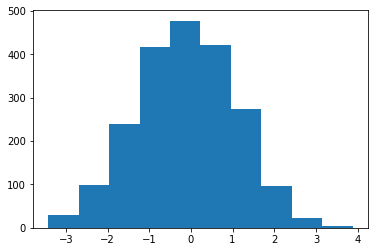

In [67]:
plt.hist(null_stats)

In [39]:
# Count tests
num_tests = 0
for pair, gene_list in all_stats.items():
    num_tests += len(gene_list)

In [69]:
num_tests

1039

In [93]:
pval_cutoff = 0.05/num_tests

In [94]:
def emp_pval(val, null_stats):
    return (null_stats >= val).mean()

In [86]:
complex_regulators = {}
for pair, gene_stats in all_stats.items():
    for gene, stats in gene_stats.items():
        s1, s2 = stats
        if s1 < 0 or s2 < 0:
            continue
        pval_1 = emp_pval(s1, null_stats)
        pval_2 = emp_pval(s2, null_stats)
        if pval_1 < pval_cutoff and pval_2 < pval_cutoff:
            if pair not in complex_regulators.keys():
                complex_regulators[pair] = []
            complex_regulators[pair].append(gene)

In [87]:
G = nx.Graph()
for pair in complex_regulators.keys():
    tf1, tf2 = pair.split('_')
    G.add_edge(tf1, tf2, weight=len(complex_regulators[pair]), color='b' if pair in edge_set else 'y')

In [88]:
pos = nx.circular_layout(truth_graph)

In [89]:
len(G.edges)

16

In [91]:
(11*10)/2

55.0

Text(0.5,1,'Predicted interactions')

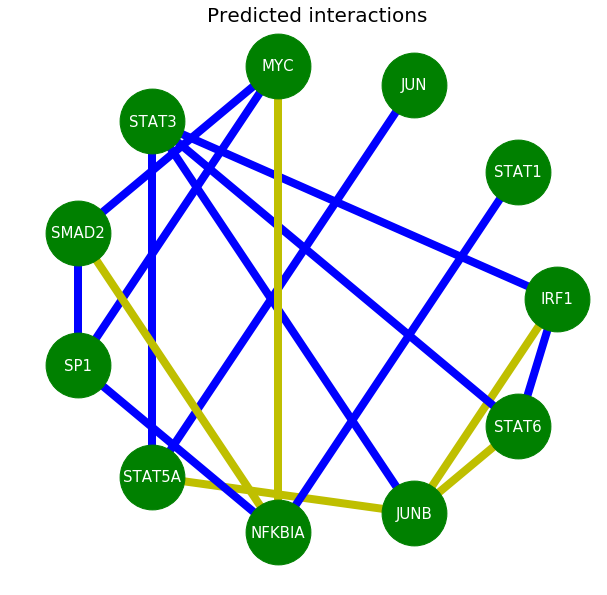

In [92]:
plt.figure(figsize=(10, 10))
colors = [G[u][v]['color'] for u,v in G.edges]
weights = [G[u][v]['weight'] for u,v in G.edges]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='g', node_size=4200, edge_color=colors, width=8, font_color='w', font_size=15);
plt.axis('off');
plt.title('Predicted interactions', fontsize=20)
#plt.savefig('/Users/mincheolkim/Documents/predicted_tf_interaction_map.png')

### Shift in distribution graph

In [130]:
# calculate correlations in WT cells
corrs = np.array([correlation('STAT3', gene, '0', label_col='ko_gene_cov')[0] for gene in hits['STAT3']])
ko_corrs = np.array([correlation('STAT3', gene, 'STAT6', label_col='ko_gene_cov')[0] for gene in hits['STAT3']])

In [131]:
# calculate correlations in WT cells
corrs_2 = np.array([correlation('STAT6', gene, '0', label_col='ko_gene_cov')[0] for gene in hits['STAT6']])
ko_corrs_2 = np.array([correlation('STAT6', gene, 'STAT3', label_col='ko_gene_cov')[0] for gene in hits['STAT6']])

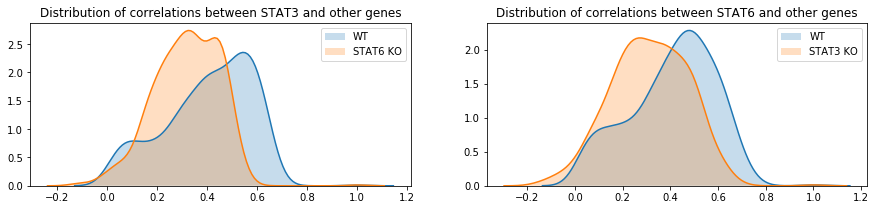

In [168]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.distplot(corrs, kde=True, bins=40, hist=False, kde_kws={"shade": True})
sns.distplot(ko_corrs, kde=True, bins=40, hist=False, kde_kws={"shade": True})
plt.title('Distribution of correlations between STAT3 and other genes')
plt.legend(['WT', 'STAT6 KO'])
#plt.savefig('/Users/mincheolkim/Documents/correlation_distribution_shift.png')
plt.subplot(1, 2, 2)
sns.distplot(corrs_2, kde=True, bins=40, hist=False, kde_kws={"shade": True})
sns.distplot(ko_corrs_2, kde=True, bins=40, hist=False, kde_kws={"shade": True})
plt.title('Distribution of correlations between STAT6 and other genes')
plt.legend(['WT', 'STAT3 KO'])

### Boxplot

The final gene set whose expression is mututally mediated by STAT3 and STAT6. 

In [171]:
print(complex_regulators['STAT3_STAT6'])

['INTS4', 'ZC3H7B', 'PWP2', 'ARL17A', 'ING5', 'DYNLL2', 'CYB5R1', 'PDXK', 'MTFR1L', 'KDM5C', 'GDI1']


In [96]:
corrs_6 = np.array([correlation('STAT3', gene, '0', label_col='ko_gene_cov')[0] for gene in complex_regulators['STAT3_STAT6']])
ko_corrs_6 = np.array([correlation('STAT3', gene, 'STAT6', label_col='ko_gene_cov')[0] for gene in complex_regulators['STAT3_STAT6']])

In [97]:
corrs_3 = np.array([correlation('STAT6', gene, '0', label_col='ko_gene_cov')[0] for gene in complex_regulators['STAT3_STAT6']])
ko_corrs_3 = np.array([correlation('STAT6', gene, 'STAT3', label_col='ko_gene_cov')[0] for gene in complex_regulators['STAT3_STAT6']])

In [120]:
boxplot_df = pd.DataFrame()

In [172]:
from scipy.stats import ks_2samp, wilcoxon

In [173]:
print(ks_2samp(corrs_6, ko_corrs_6))
print(wilcoxon(corrs_6, ko_corrs_6))

Ks_2sampResult(statistic=0.7272727272727273, pvalue=0.0025221541349046404)
WilcoxonResult(statistic=0.0, pvalue=0.0033456181158508813)


In [174]:
print(ks_2samp(corrs_3, ko_corrs_3))
print(wilcoxon(corrs_3, ko_corrs_3))

Ks_2sampResult(statistic=0.9090909090909091, pvalue=5.901179037670526e-05)
WilcoxonResult(statistic=0.0, pvalue=0.0033456181158508813)


In [126]:
boxplot_df['wt_stat3_gene'] = corrs_6
boxplot_df['stat6ko_stat3_gene'] = ko_corrs_6
boxplot_df['wt_stat6_gene'] = corrs_3
boxplot_df['stat3ko_stat6_gene'] = ko_corrs_3

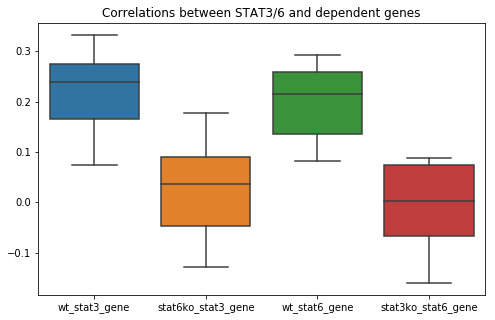

In [169]:
plt.figure(figsize=(8, 5))
plt.title('Correlations between STAT3/6 and dependent genes')
sns.boxplot(data=boxplot_df)